In [1]:
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
from multiinstance.likelihood_method import getChildren, treeNegativeLogLikelihood,runAlgorithm, plotDistrs, plotMAE
from multiinstance.data.syntheticData import buildDataset
import scipy.stats as ss

In [3]:
from multiinstance.data.realData import buildDataset as buildReal

In [4]:
from multiinstance.utils import addTransformScores, addGlobalEsts, getBagAlphaHats,getEsts,getTransformScores

In [5]:
# export likelihood_method
def prepDS(dsi,numbootstraps=10, useAlphaMax=True):
    dsi = addTransformScores(dsi)
    dsi = addGlobalEsts(dsi,useAlphaMax=useAlphaMax,reps=numbootstraps)
    dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,
                                               numbootstraps=numbootstraps,
                                               useAlphaMax=useAlphaMax)

    dsi.numLeaves = dsi.alphaHats.shape[0]
    dsi.numNodes = dsi.numLeaves + (dsi.numLeaves - 1)
    dsi.numInternal = dsi.numNodes - dsi.numLeaves

    dsi.mu = np.zeros(dsi.alphaHats.shape[0])
    dsi.sigma = np.ones(dsi.numNodes)
    dsi.leafN = np.ones_like(dsi.mu) * dsi.alphaHats.shape[1]
    dsi.treeAlphaHats = [[] for _ in range(dsi.numNodes)]

    for nodeNum in range(dsi.numInternal):
        children = getChildren(nodeNum, dsi.numInternal)
        leafNums = children - dsi.numInternal
        _,unlabeled = list(zip(*[getTransformScores(dsi,n) for n in leafNums]))
        pos,_ = list(zip(*[getTransformScores(dsi,n) for n in range(dsi.N)]))
        pos = np.concatenate(pos).reshape((-1,1))
        unlabeled = np.concatenate(unlabeled).reshape((-1,1))
        NEstimates = int(np.sum([dsi.leafN[l] for l in leafNums]))
        dsi.treeAlphaHats[nodeNum],_ = getEsts(pos, unlabeled, NEstimates,useAlphaMax=useAlphaMax)
        _, dsi.sigma[nodeNum] = ss.norm.fit(dsi.treeAlphaHats[nodeNum])

    for leafNum in range(dsi.numLeaves):
        nodeNum = leafNum + dsi.numInternal
        dsi.treeAlphaHats[nodeNum] = dsi.alphaHats[leafNum]
        dsi.mu[leafNum],dsi.sigma[nodeNum] = ss.norm.fit(dsi.treeAlphaHats[nodeNum])
    return dsi



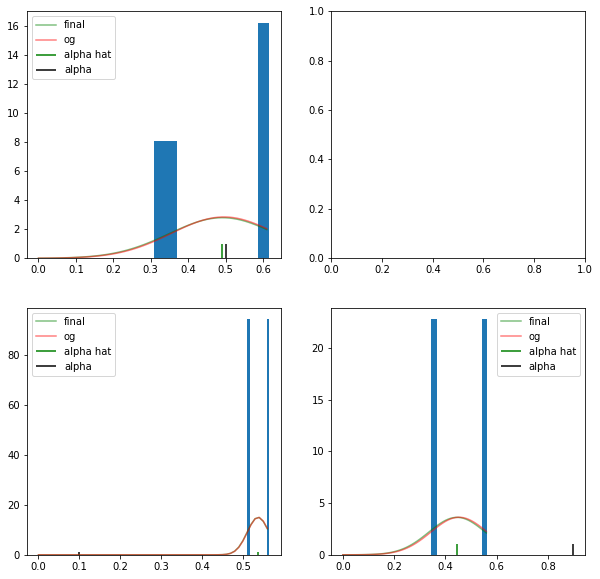

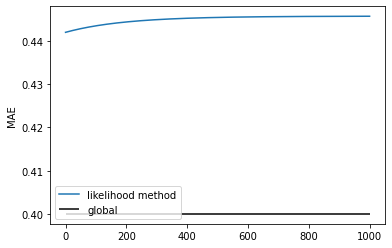

In [6]:
dsi = buildDataset(1,nP=23,nU=100,posMean=1,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.10]))
ds2 = buildDataset(1, nP=23,nU=100,posMean=1,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.90]))
dsi.merge(ds2)

dsi = prepDS(dsi,numbootstraps=2,useAlphaMax=False)
dsi, mus,sigmas,maes,logLikelihood = runAlgorithm(dsi,
                                                  NIter=1000,
                                                  rlambda=1,)

fig = plotDistrs(dsi,mus,sigmas)

fig2 = plotMAE(maes,dsi)

In [7]:
def run(fileName,useAlphaMax=False):
    dsn = fileName.split("/")[-1].replace(".mat","")
    dsi = buildReal(fileName,4,
                       alphaDistr=lambda: np.random.uniform(.05,.95),
                      nPDistr=lambda: 1 + np.random.poisson(25),
                      nUDistr=lambda: 1 + np.random.poisson(75))
    dsi = prepDS(dsi,numbootstraps=25,useAlphaMax=useAlphaMax)
    dsi, mus,sigmas,maes,NLL = runAlgorithm(dsi,
                                            NIter=2500,
                                            rlambda=1,)
    localAE = maes[0] * dsi.N
    likelihoodAE = maes[-1] * dsi.N
    globalAE = np.abs(dsi.globalAlphaHats.mean() - dsi.trueAlphas.flatten()).sum()
    maeFig = plotMAE(maes,dsi)
    plt.show()
    dstrFig = plotDistrs(dsi,mus,sigmas)
    plt.show()
    nllFig,ax= plt.subplots()
    ax.plot(NLL)
    plt.show()
    if useAlphaMax:
        mode = "alphamax"
    else:
        mode = "distcurve"
    maeFig.savefig("figs/nb_24/{}_{}_mae.pdf".format(dsn,mode),format="pdf")
    nllFig.savefig("figs/nb_24/{}_{}_nll.pdf".format(dsn,mode),format="pdf")
    dstrFig.savefig("figs/nb_24/{}_{}_distr.pdf".format(dsn,mode),format="pdf")
    return localAE, globalAE, likelihoodAE,dsi.N

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/mol_bio.mat
DistCurve


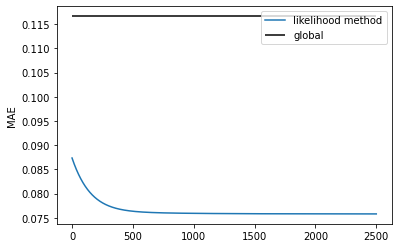

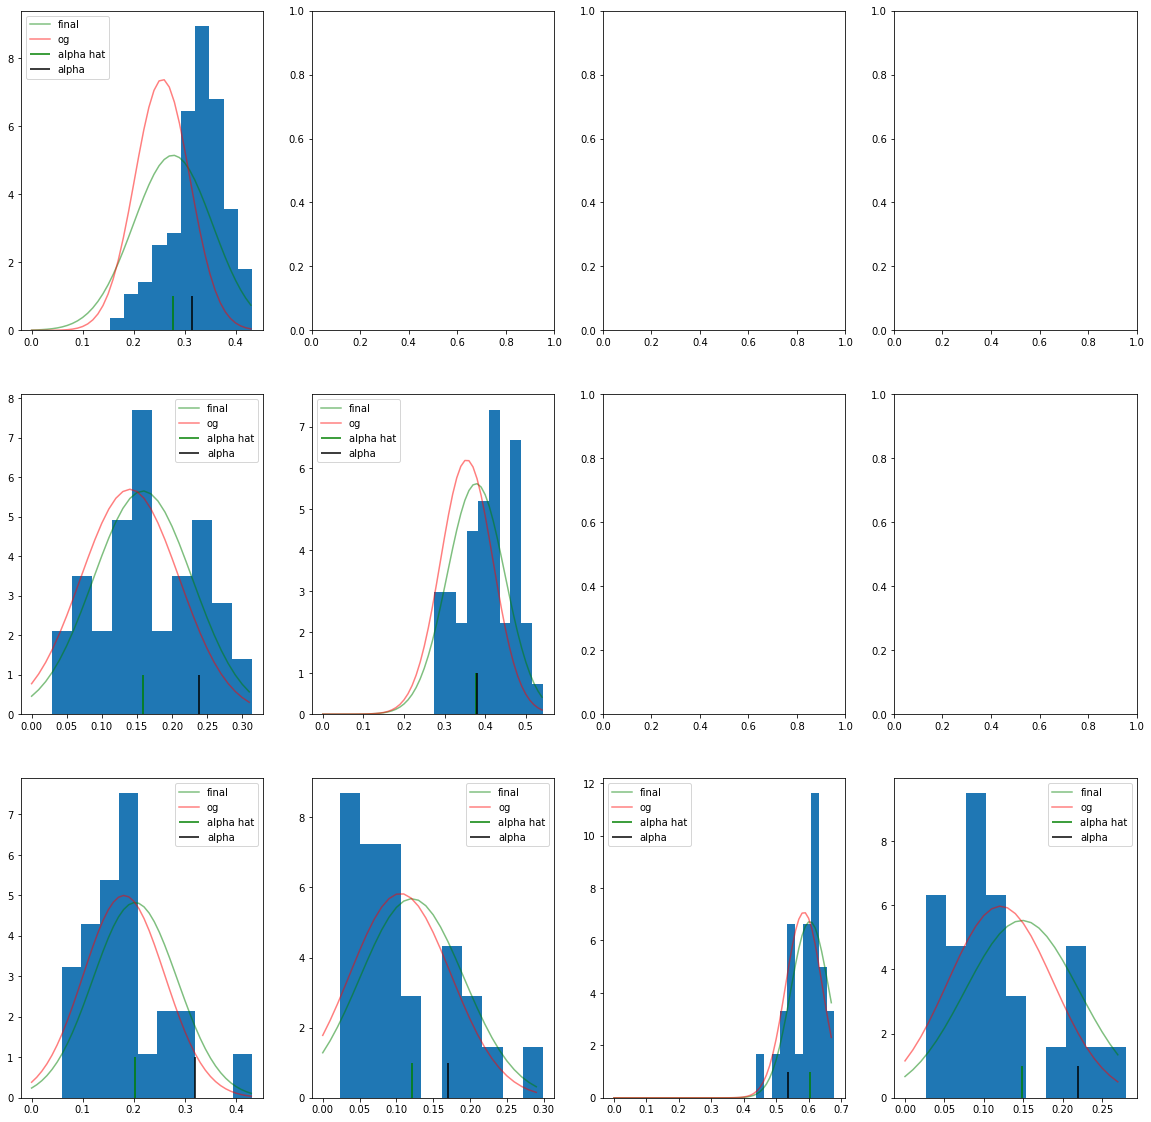

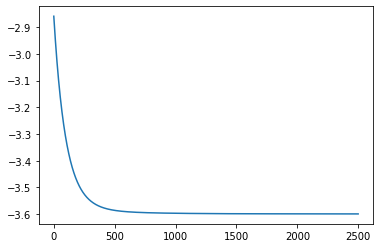

local 0.087
global 0.117
likelihood 0.076
Alphamax


In [ ]:
# fileNames = glob("/data/dzeiberg/ClassPriorEstimation/rawDatasets/*.mat")
fileNames = glob("/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/*.mat")
absErrs = {"distcurve":{"local":0,
           "global":0,
           "likelihood":0},
           "alphamax":{"local":0,
           "global":0,
           "likelihood":0}}
N = 0
for fileName in tqdm(fileNames,total=len(fileNames)):
    print(fileName)
    # RUN DISTCURVE
    print("DistCurve")
    localAE, globalAE, likelihoodAE,ni = run(fileName, useAlphaMax=False)
    # Log Results
    N += ni
    absErrs["distcurve"]["local"] += localAE
    absErrs["distcurve"]["global"] += globalAE
    absErrs["distcurve"]["likelihood"] += likelihoodAE
    for k,v in absErrs["distcurve"].items():
        print(k, "{:.3f}".format(v/N))
    # AlphaMax
    print("Alphamax")
    localAE, globalAE, likelihoodAE,_ = run(fileName, useAlphaMax=True)
    # Log Results
    absErrs["alphamax"]["local"] += localAE
    absErrs["alphamax"]["global"] += globalAE
    absErrs["alphamax"]["likelihood"] += likelihoodAE
    for k,v in absErrs["alphamax"].items():
        print(k, "{:.3f}".format(v/N))
    

In [ ]:
fileNames

In [ ]:
absErrs